## Collaborative rating using Movielens
Forked from [lesson5-movielens.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson5-movielens.ipynb).

**Goal: Given a set of user-movie-ratings, predict the rating for a new user-movie combination.**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Download [small Data](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

In [2]:
path='data/ml-latest-small/'
#path='data/ml-latest/'

In [3]:
import pandas as pd

The movielens data contains one user-rating-movie per row:

In [4]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


We use `userId`, `movieId` (both categorical),  and `rating` as dependent.

Just for display purposes, let's read in the movie names too.

In [5]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Data Exploration:
Who are the top (n) contributors? 
Which are the top (n) movies?

In [6]:
topn = 15
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:topn]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:topn]

Below prints movieId and name.

In [7]:
movie_names = movies.set_index('movieId')['title'].to_dict()
topMovieslist = iter(topMovies.index)
MostRatedmovie_names = pd.Series(movie_names, index=topMovieslist)
print("Most rated Movies:")
print("Movie id\t\t\tMovie Name (Year)\n")
print(MostRatedmovie_names[0:topn])

Most rated Movies:
Movie id			Movie Name (Year)

356                                   Forrest Gump (1994)
296                                   Pulp Fiction (1994)
318                      Shawshank Redemption, The (1994)
593                      Silence of the Lambs, The (1991)
260             Star Wars: Episode IV - A New Hope (1977)
480                                  Jurassic Park (1993)
2571                                   Matrix, The (1999)
1                                        Toy Story (1995)
527                               Schindler's List (1993)
589                     Terminator 2: Judgment Day (1991)
1196    Star Wars: Episode V - The Empire Strikes Back...
110                                     Braveheart (1995)
1270                            Back to the Future (1985)
608                                          Fargo (1996)
1198    Raiders of the Lost Ark (Indiana Jones and the...
dtype: object


## Create subset for Excel

We create a crosstab of the most reviewed movies and the top contributing reviewers.<br>
Panda's `crosstab` computes a simple cross-tabulation of two (or more) factors. 
By default computes a frequency table of the factors, unless an array of values and an aggregation function are passed.
Here we pass the top users, top movies, and top ratings, with an aggregation function of `np.sum`
```
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)
```
We copy this table to Excel for a simple example. (Not necessary for the modeling below)

In [8]:
import numpy as np

In [9]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

Use `CollabFilterDataset.from_csv` to load the ratings file columns userid, movieId and rating, and return an object.

In [10]:
from fastai.column_data import CollabFilterDataset  #*

In [11]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')

In [12]:
from fastai.dataset import get_cv_idxs

We create a validation set by picking random set of ID’s. 
- `wd` is a weight decay for L2 regularization
- `n_factors` is size of embedding matrix.

In [13]:
val_idxs = get_cv_idxs(len(ratings))   # validation indeces
n_factors = 50  # size of embedding matrix
bs = 64  # Batch size

In [14]:
from torch import optim

get a learner that is suitable for the model data, and then fit the model:
```
get_learner(self, n_factors, val_idxs, bs, **kwargs) 
```
returns a learner

In [15]:
learn = cf.get_learner(n_factors, val_idxs, bs, opt_fn=optim.Adam)

In [16]:
lr = 1e-2
wd = 2e-4   # Weight decay

`learn.fit` args: 
* `lrs` (float or list(float)): learning rate for the model
* `n_cycle` (int): number of cycles (or iterations) to fit the model for
* `wds` (float or list(float)): weight decay parameter(s).
* `kwargs`: other arguments

**NB: Below step takes hours about 3 hours to complete on the bigger dataset....Wall time: 2h 57min 14s
On the smaller dataset only 21 sec.**

In [17]:
%time lf = learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2, use_wd_sched=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.839171   0.83056   
    1      0.693355   0.937917                                  
    2      0.300908   0.895408                                  

CPU times: user 19.4 s, sys: 3.19 s, total: 22.6 s
Wall time: 17.9 s


Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We need to take the square root of the loss, since we use plain MSE.

In [18]:
lf

[array([0.89541])]

In [19]:
from math import sqrt
sqrt(lf[0])

0.9462598007480714

Looking good - we've found a solution (same/better) than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [20]:
preds = learn.predict()

In [21]:
import seaborn as sns

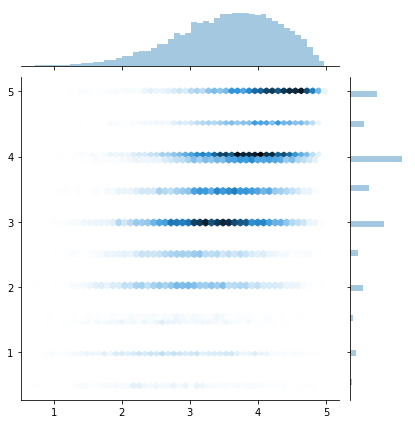

In [22]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [23]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [24]:
learn.models.model  # this is where the model is kept

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

In [25]:
m=learn.model; m.cuda()   # shortcut

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

One nice thing about Pytorch is that all layers can be invoked as if they were functions, e.g., m.ib() returns the movie bias.  

Pytorch Layers require Variables, not tensors, so they can compute the gradients... So we must pass Variables to models.
But now it was announced that in Pytorch 0.4 there will no longer need Variables, ie we can pass the tensors directly! 

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).  Each movie has a single bias

In [26]:
from fastai.learner import V #*  V wraps it into a Variable

In [27]:
m.ib(V(topMovieIdx))  # passing a variable to the model for all the top indeces, returns a Variable of size 3000 with the biases

Variable containing:
 8.2456e-01
 8.6981e-01
 1.2382e+00
     ⋮      
 6.2747e-01
 7.9842e-02
 3.8878e-01
[torch.cuda.FloatTensor of size 3000x1 (GPU 0)]

In [28]:
from fastai.core import to_np  # to_np returns an np array

In [29]:
movie_bias = to_np(m.ib(V(topMovieIdx)))   #to_np is convert to numpy (fastai shortcut)

In [30]:
movie_bias    # now in numpy

array([[0.82456],
       [0.86981],
       [1.23816],
       ...,
       [0.62747],
       [0.07984],
       [0.38878]], dtype=float32)

JH approach, always use **numpy** unless you need GPU or a Variable.   Fastai libriary follows this approach, it does as much as possible in numpy.

Now grab each movie along with its bias term, with zip we get it into a list of tuples, 
so we can then use it in a list comprehension to iterate over all the the movies.
Lets get all the movie ratings.

In [31]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

About sorting key — Python has itemgetter function but plain lambda is just one more character,
so we use lambda as the key sorter, and show the "top" (worst) 15 movies

In [32]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.78558517, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.78204393, 'Inspector Gadget (1999)'),
 (-0.7811187, 'Battlefield Earth (2000)'),
 (-0.7736202, 'Super Mario Bros. (1993)'),
 (-0.7302514, 'Anaconda (1997)'),
 (-0.6974814, 'Avengers, The (1998)'),
 (-0.68733764, 'Wild Wild West (1999)'),
 (-0.684902, 'Cutthroat Island (1995)'),
 (-0.66277343, 'Speed 2: Cruise Control (1997)'),
 (-0.65339607,
  'Halloween: The Curse of Michael Myers (Halloween 6: The Curse of Michael Myers) (1995)'),
 (-0.64987206, 'Karate Kid, Part III, The (1989)'),
 (-0.60783297, 'Blame It on Rio (1984)'),
 (-0.58013815, 'Spice World (1997)'),
 (-0.57842964, "Joe's Apartment (1996)"),
 (-0.57627165, 'Jaws 3-D (1983)')]

Equivalent to above (with lambda) but using the `itemgetter` operator.

In [33]:
from operator import itemgetter
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.78558517, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.78204393, 'Inspector Gadget (1999)'),
 (-0.7811187, 'Battlefield Earth (2000)'),
 (-0.7736202, 'Super Mario Bros. (1993)'),
 (-0.7302514, 'Anaconda (1997)'),
 (-0.6974814, 'Avengers, The (1998)'),
 (-0.68733764, 'Wild Wild West (1999)'),
 (-0.684902, 'Cutthroat Island (1995)'),
 (-0.66277343, 'Speed 2: Cruise Control (1997)'),
 (-0.65339607,
  'Halloween: The Curse of Michael Myers (Halloween 6: The Curse of Michael Myers) (1995)'),
 (-0.64987206, 'Karate Kid, Part III, The (1989)'),
 (-0.60783297, 'Blame It on Rio (1984)'),
 (-0.58013815, 'Spice World (1997)'),
 (-0.57842964, "Joe's Apartment (1996)"),
 (-0.57627165, 'Jaws 3-D (1983)')]

Now reverse sorting to find the top rated movies

In [34]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.238157, 'Shawshank Redemption, The (1994)'),
 (1.0280702, 'Godfather, The (1972)'),
 (0.94336665, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (0.8809705, '12 Angry Men (1957)'),
 (0.86980575, 'Pulp Fiction (1994)'),
 (0.852401, 'Matrix, The (1999)'),
 (0.83742297, "Schindler's List (1993)"),
 (0.8245559, 'Forrest Gump (1994)'),
 (0.81813765, 'Usual Suspects, The (1995)'),
 (0.81392545, 'Silence of the Lambs, The (1991)'),
 (0.8136644, 'Fargo (1996)'),
 (0.8133239, 'Princess Bride, The (1987)'),
 (0.81265855, 'Life Is Beautiful (La Vita è bella) (1997)'),
 (0.8008502, 'Stand by Me (1986)'),
 (0.7997346, 'How to Train Your Dragon (2010)')]

### Embedding interpretation

We can now do the same thing to look at the embeddings. (m.i)

In [35]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 dimensional space.  Linear techniques work well for this type of embedings.
Turns out PCA is very similar to Singular Value Decomposition (SVD) which from time to time turns out in DL.

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)   # find 3 linear combinations that are different from each other as possible
movie_pca = pca.fit(movie_emb.T).components_   # grab the 3 components

In [37]:
movie_pca.shape

(3, 3000)

In [38]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

We don't know apriori what is the interpretation for the latent factor identified by each component....
Here's the 1st component, the principal axis. So lets try to give it an interpretation....  JH called it 'easy watching' vs 'serious'.

In [39]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.047042497, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.043965533, 'Police Academy 4: Citizens on Patrol (1987)'),
 (0.043257564, 'Jack Frost (1998)'),
 (0.042683307, 'Police Academy 3: Back in Training (1986)'),
 (0.04204044, 'Howard the Duck (1986)'),
 (0.04202136, 'Karate Kid, Part III, The (1989)'),
 (0.04128988, 'Striptease (1996)'),
 (0.04126815, 'Battlefield Earth (2000)'),
 (0.039933193, 'Mighty Ducks, The (1992)'),
 (0.039535493, 'Bodyguard, The (1992)')]

In [40]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.06043315, 'On the Waterfront (1954)'),
 (-0.05482717, 'Killing Fields, The (1984)'),
 (-0.054793157, 'Name of the Rose, The (Name der Rose, Der) (1986)'),
 (-0.054689657, 'Raging Bull (1980)'),
 (-0.054472174, 'Yojimbo (1961)'),
 (-0.05110252, 'Memento (2000)'),
 (-0.050563633, 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)'),
 (-0.05041541, 'Godfather, The (1972)'),
 (-0.04960831, 'Godfather: Part II, The (1974)'),
 (-0.048970167, 'Dog Day Afternoon (1975)')]

In [41]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the $2nd$ component. More difficult to interpret...  To JH seems to be 'CGI' vs 'dialog driven'.

In [42]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.05731613, '9 1/2 Weeks (Nine 1/2 Weeks) (1986)'),
 (0.056074023, 'Pledge, The (2001)'),
 (0.051510192, 'It Follows (2014)'),
 (0.049074117, 'Battle of Algiers, The (La battaglia di Algeri) (1966)'),
 (0.04837076, 'Amateur (1994)'),
 (0.048065674, '2001: A Space Odyssey (1968)'),
 (0.04734628, 'Crash (1996)'),
 (0.04656857, 'Thirty-Two Short Films About Glenn Gould (1993)'),
 (0.04637845, 'Nightcrawler (2014)'),
 (0.0459202, 'Transformers: Dark of the Moon (2011)')]

In [43]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.06793436, 'Clerks II (2006)'),
 (-0.067066155, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.06704076, 'Lincoln (2012)'),
 (-0.06424755, 'Muppets From Space (1999)'),
 (-0.058874205, 'Sweet Home Alabama (2002)'),
 (-0.056029063, "Dr. Horrible's Sing-Along Blog (2008)"),
 (-0.055792667, 'Dish, The (2001)'),
 (-0.05424689, 'Mad Max: Fury Road (2015)'),
 (-0.054016307, 'Fountain, The (2006)'),
 (-0.05364851, 'Wings of Desire (Himmel über Berlin, Der) (1987)')]

#### Plot
We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

In [44]:
from matplotlib import pyplot as plt

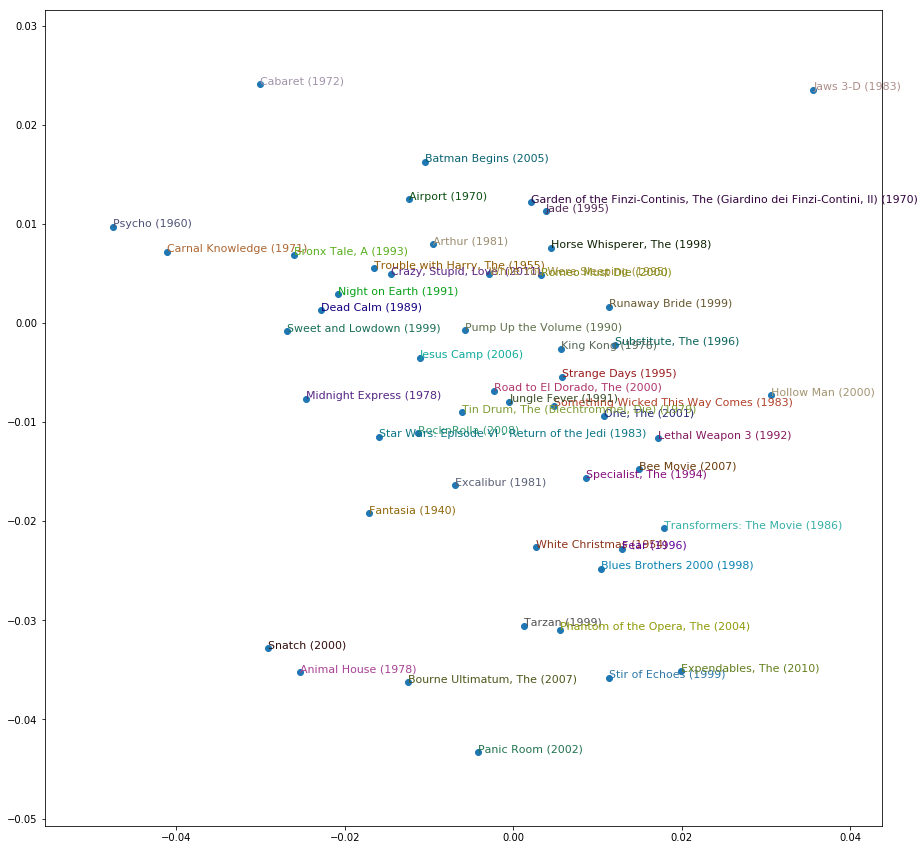

In [45]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example (aka inner product)

In [46]:
from fastai.core import T

In [47]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)], 
   2   2
  10  10
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)])

In [48]:
a*b   # element by element


  2   4
 30  40
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

In [49]:
(a*b).sum(1)   # the dot product


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

In [50]:
import torch.nn as nn

In [51]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [52]:
model=DotProduct()

In [53]:
model(a,b)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

### Dot product model

Building a more complex module 
[41:31]
This implementation has two additions to the DotProduct class:

- Two `nn.Embedding` matrices
- Look up our users and movies in above embedding matrices

It is quite possible that user ID’s are not contiguous which makes it hard to use as an index of embedding matrix. So we will start by creating indexes that starts from zero and contiguous and replace ratings.userId column with the index by using Panda’s apply function with an anonymous function lambda and do the same for ratings.movieId .

In [54]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [55]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

Note that __init__ is a constructor, now needed to keep track of “states” (how many movies, users, factors, etc). 
We initialized the weights to random numbers between 0 and 0.05 and you can find more information about a standard algorithm for weight initialization, [“Kaiming Initialization”](http://www.jefkine.com/deep/2016/08/08/initialization-of-deep-networks-case-of-rectifiers/)
(PyTorch has He initialization utility function but we are doing things from scratch) [46:58].

**NB: Below changes for Pytorch 0.4 where Tensors and Variables have merged **

`Embedding` is not a tensor but a **variable**. 
A variable does the same operations as a tensor **and** it also does automatic differentiation. 
To pull a tensor out of a variable, call data attribute. 
All the tensor functions have a variation with trailing underscore (e.g. uniform_) will do things in-place.

In [56]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [57]:
from fastai.column_data import ColumnarModelData

We use `ColumnarModelData` (eg from Rossmann notebook), and that is the reason why there are both categorical and continuous variables in 
```
def forward(self, cats, conts) 
```
function in `EmbeddingDot class` [50:20]. 
Since we do not have continuous variables, we  ignore conts, and use the 1st and 2nd columns of cats as users and movies. 
NB: they are mini-batches of users and movies. 
Do **not** manually loop through mini-batches because you will not get GPU acceleration. 
Process a whole mini-batch at a time as you see in line 3 and 4 of forward function above [51:00–52:05].

In [58]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [59]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

`optim` gives us the optimizers in PyTorch. 
`model.parameters()` is inherited from `nn.Modules` that gives us all the weight to be updated/learned.

In [60]:
from fastai.learner import fit
from fastai.conv_learner import F 

`fit` below is from fast.ai library [54:40] and is closer to the PyTorch approach compared to learner.fit(). 
`fit` will not have features like SGDR or DLR. 

In [61]:
%time fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                 
    0      1.631819   1.624081  
    1      1.091112   1.293502                                 
    2      0.892323   1.231286                                  

CPU times: user 15 s, sys: 3.21 s, total: 18.2 s
Wall time: 13.6 s


[array([1.23129])]

In [62]:
from fastai.layer_optimizer import set_lrs
set_lrs(opt, 0.01)

In [63]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.740176   1.148199  
    1      0.681263   1.136883                                  
    2      0.70395    1.129538                                  



[array([1.12954])]

### Bias
 to adjust for generally popular movies or generally enthusiastic users.

In [64]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [65]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

`squeeze()` is PyTorch version of broadcasting [1:04:11] for more information, see Machine Learning class or numpy documentation.

We squish the ratings so that they are between 1 and 5.
By putting the prediction through sigmoid results in numbers between 1 and 0. 
So in this case, we can multiply that by 4 and add 1 — which will result in number between 1 and 5.

`F` is a PyTorch functional (torch.nn.functional) that contains all functions for tensors, and is imported as F in most cases.

In [66]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [67]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.793926   0.834058  
    1      0.793727   0.818716                                  
    2      0.801612   0.806773                                  



[array([0.80677])]

In [68]:
from fastai.layer_optimizer import set_lrs

In [69]:
set_lrs(opt, 1e-2)

In [70]:
%time fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.752735   0.801076  
    1      0.778655   0.800215                                  
    2      0.736021   0.799759                                  

CPU times: user 18.8 s, sys: 3.1 s, total: 21.9 s
Wall time: 16.9 s


[array([0.79976])]

### Mini net

Neural Net Version [1:17:21]
We go back to excel sheet to understand the intuition. Notice that we create user_idx to look up Embeddings just like we did in the python code earlier. If we were to one-hot-encode the user_idx and multiply it by user embeddings, we will get the applicable row for the user. If it is just matrix multiplication, why do we need Embeddings? It is for computational performance optimization purposes.
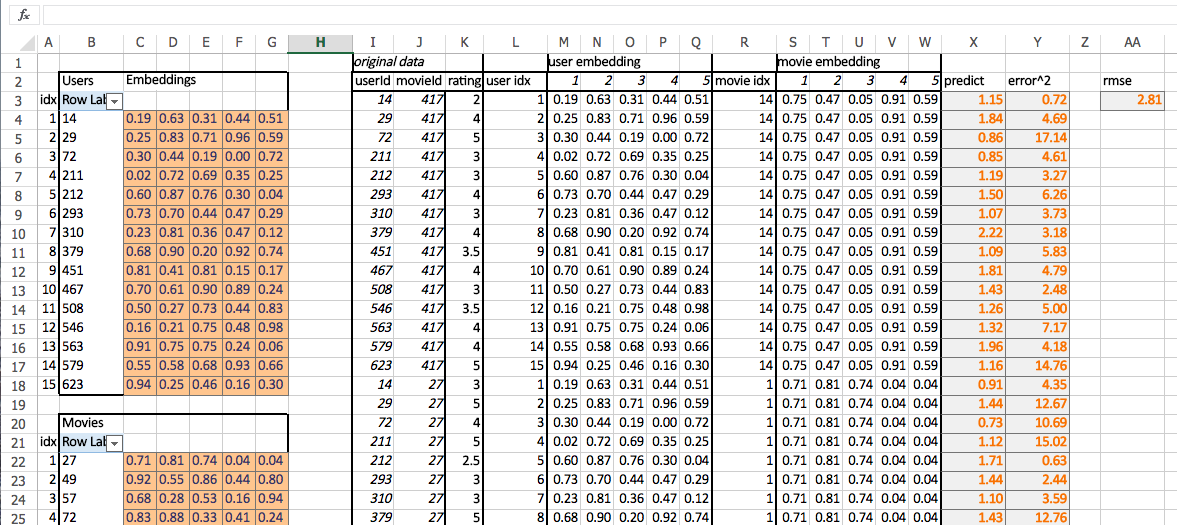

Rather than calculating the dot product of user embedding vector and movie embedding vector to get a prediction, 
we will concatenate the two and feed it through neural net.

In [71]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

`nn.Linear` already includes a bias.
Notice that we no longer has bias terms since Linear layer in PyTorch already has a built in bias. 
- `nh` is a number of activations a linear layer creates (“num hidden”).
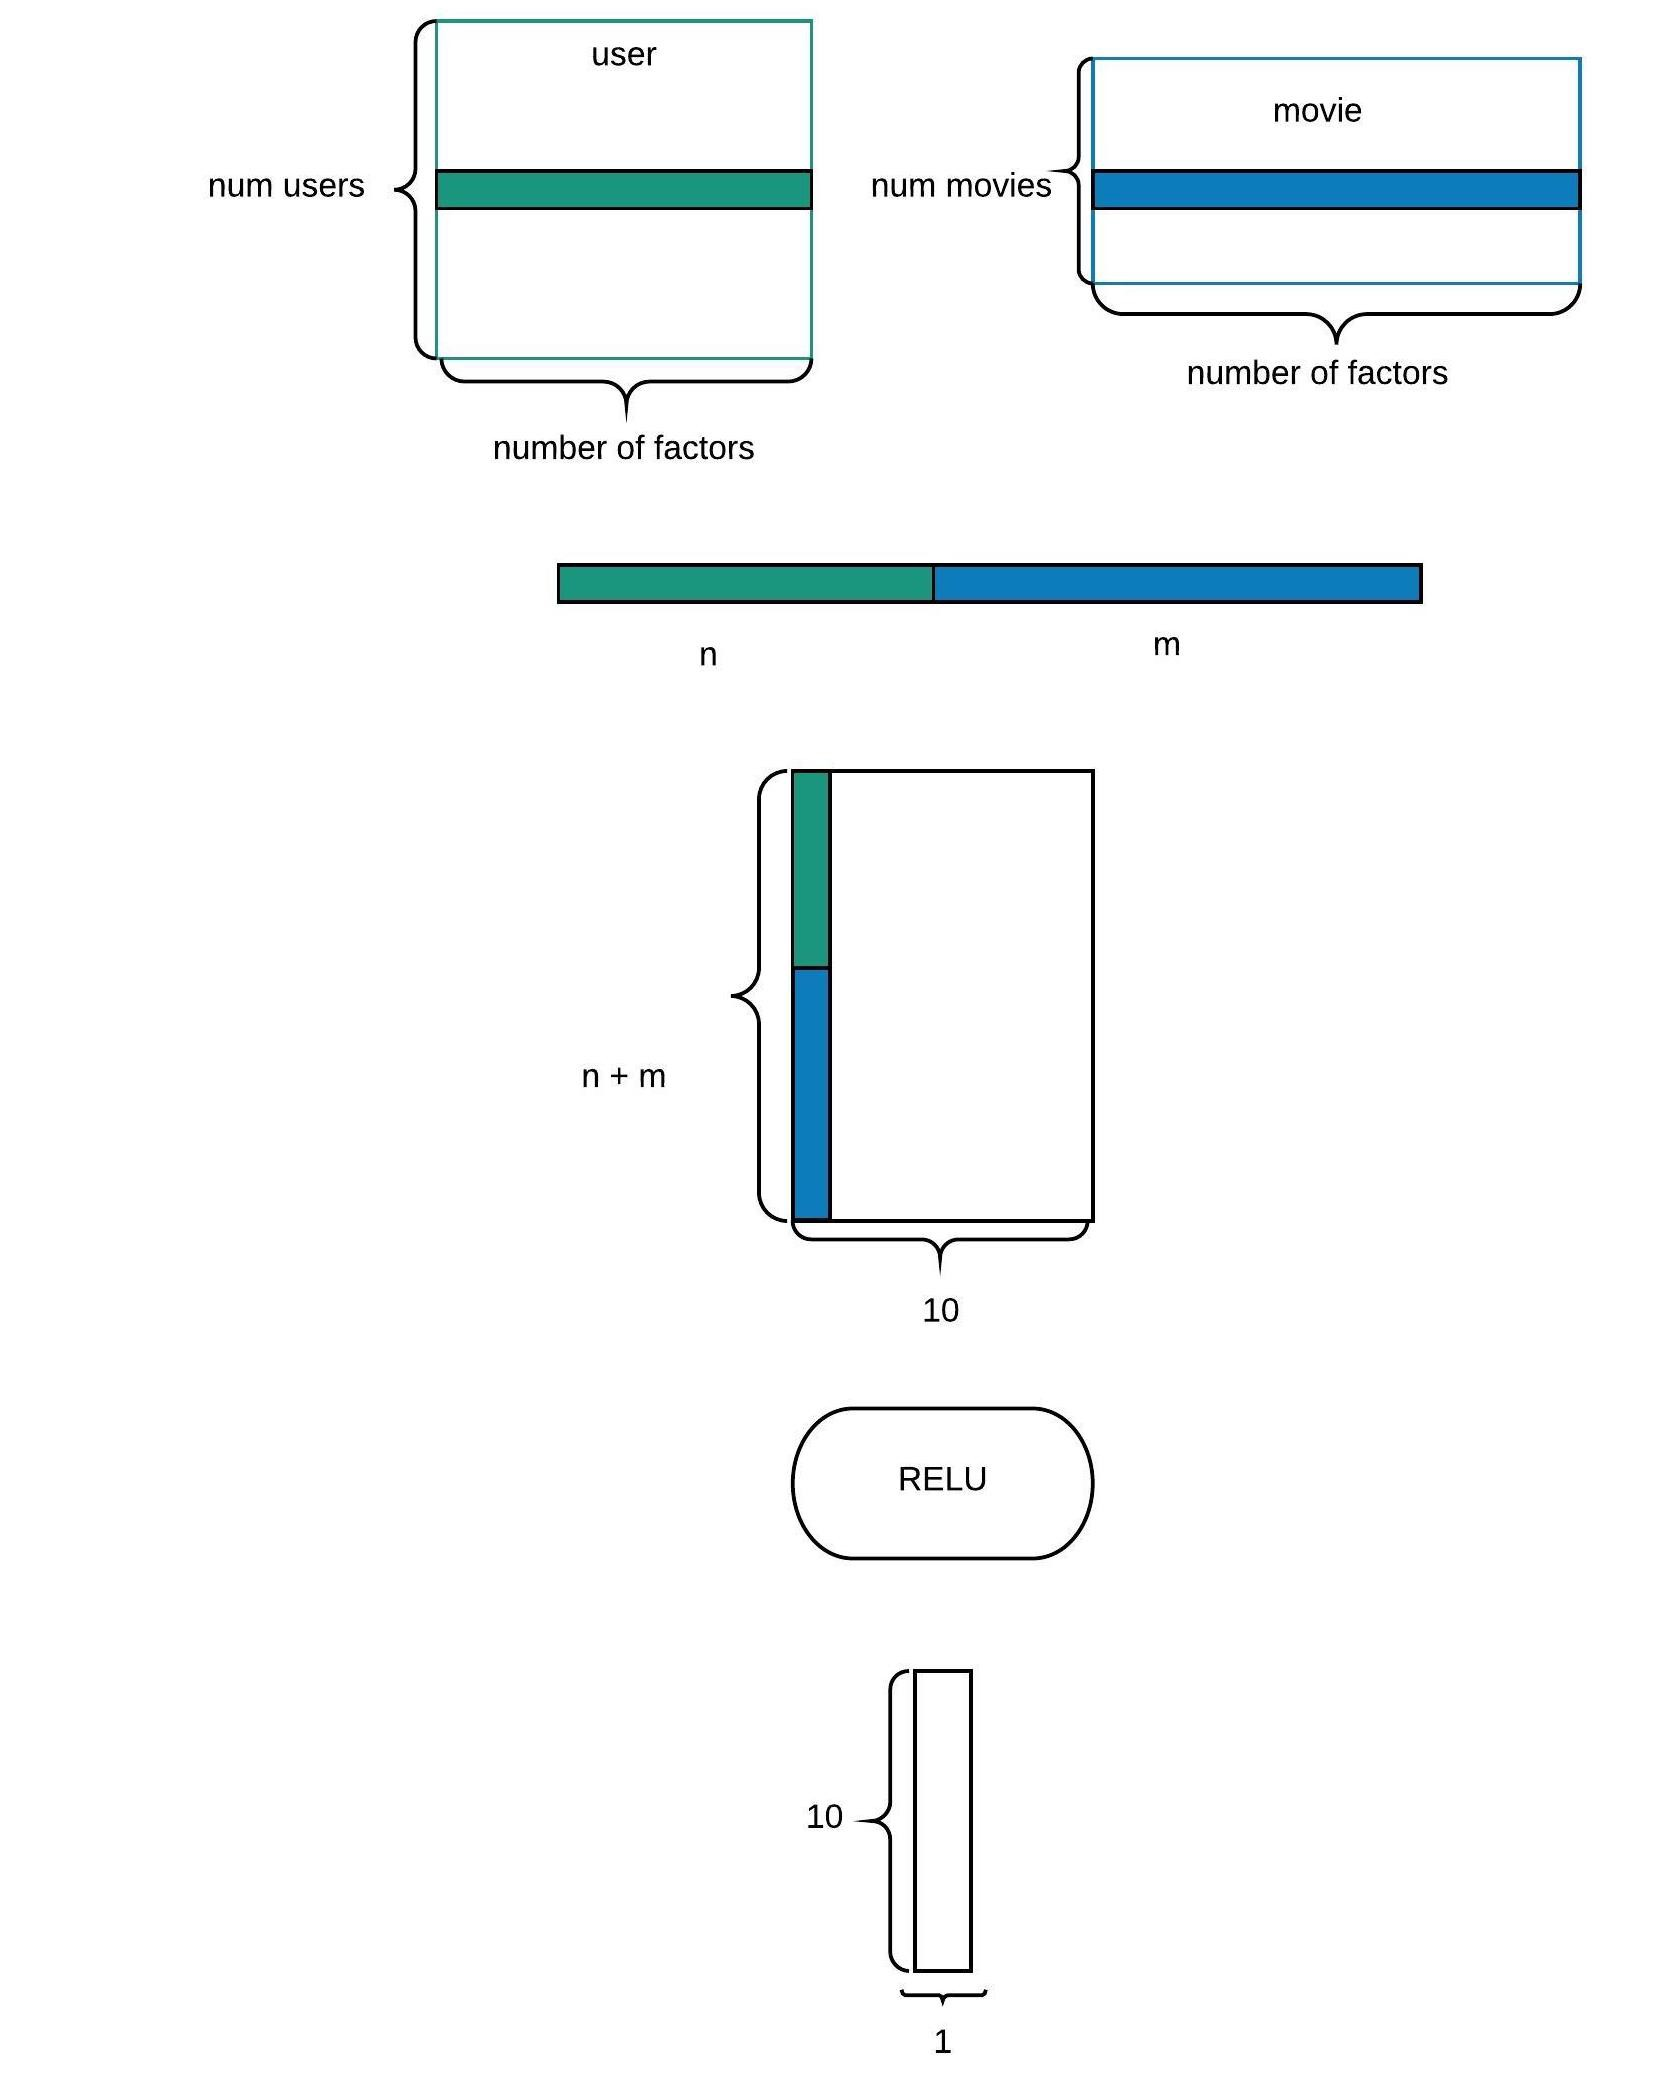

It only has one hidden layer, so maybe not “deep”, but this is definitely a neural network.



In [72]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [73]:
import torch

In [74]:
%time fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.919611   0.814257  
    1      0.834824   0.794566                                  
    2      0.796381   0.790678                                  

CPU times: user 21.7 s, sys: 3.21 s, total: 24.9 s
Wall time: 19.7 s


[array([0.79068])]

Notice that the loss functions are also in F (here, it s mean squared loss).

Now that we have neural net, there are many things we can try:
- Add dropouts
- Use different embedding sizes for user embedding and movie embedding
- Not only user and movie embeddings, but append movie genre embedding and/or timestamp from the original data.
- Increase/decrease number of hidden layers and activations
- Increase/decrease regularization

In [75]:
set_lrs(opt, 1e-3)

In [76]:
%time fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.755018   0.7871    
    1      0.808613   0.78646                                   
    2      0.758093   0.791442                                  

CPU times: user 21.8 s, sys: 3.22 s, total: 25.1 s
Wall time: 19.7 s


[array([0.79144])]

In [77]:
# END